In [1]:
import pandas as pd
import numpy as np
import requests
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
plt.style.use("seaborn")

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Defining Features and Classifier

In [2]:
df_multi = pd.read_csv("Fire_multi.csv", index_col=False)

In [3]:
df_multi.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
0,2596,51,3,258,0,510,221,232,148,0,5,29


In [4]:
X = df_multi.drop("Horizontal_Distance_To_Fire_Points",axis=1)
y = df_multi["Horizontal_Distance_To_Fire_Points"]

In [5]:
#Splitting the set (test = 0.3) in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,stratify=y, random_state=4444)

In [6]:
#scaling the features
sca = StandardScaler()
sca.fit_transform(X_train)
sca.transform(X_test);

In [7]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [8]:
def grid_estimator(estimator, param_grid, X_train, y_train, X_test, y_test, cv=5):
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, n_jobs=1)
    grid.fit(X_train, y_train)
    print("Accuracy training: " + str(grid.best_score_))
    y_pred = grid.predict(X_test)
    print("Accuracy test: " + str(accuracy_score(y_pred,y_test)))
    print(grid.best_estimator_)


In [26]:
def conf_trees(y, y_pred):
    trees_confusion = confusion_matrix(y, y_pred)
    plt.figure(dpi=180)
    sns.heatmap(trees_confusion, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 16}, square=True, fmt='d',
               xticklabels=["0","1","2"],
               yticklabels=["0","1","2"]);
    plt.tick_params(axis="both", labelsize=14)
    plt.xlabel('prediction', fontsize = 14)
    plt.ylabel('actual', fontsize = 14);

### Trying Random Forest Classifier with default values 

In [11]:
param_grid = {}
grid_estimator(RandomForestClassifier(), param_grid, X_train, y_train, X_test, y_test)

Accuracy training: 0.915715943625402
Accuracy test: 0.927867404075638
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [12]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
feature_viewer = {}
for col, score in zip(X.loc[:,:].columns, rf.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Elevation                           0.195751
Aspect                              0.063699
Slope                               0.044371
Horizontal_Distance_To_Hydrology    0.086872
Vertical_Distance_To_Hydrology      0.092131
Horizontal_Distance_To_Roadways     0.206287
Hillshade_9am                       0.049455
Hillshade_Noon                      0.050913
Hillshade_3pm                       0.053027
Cover_Type                          0.043319
Soil_Type                           0.114175
dtype: float64

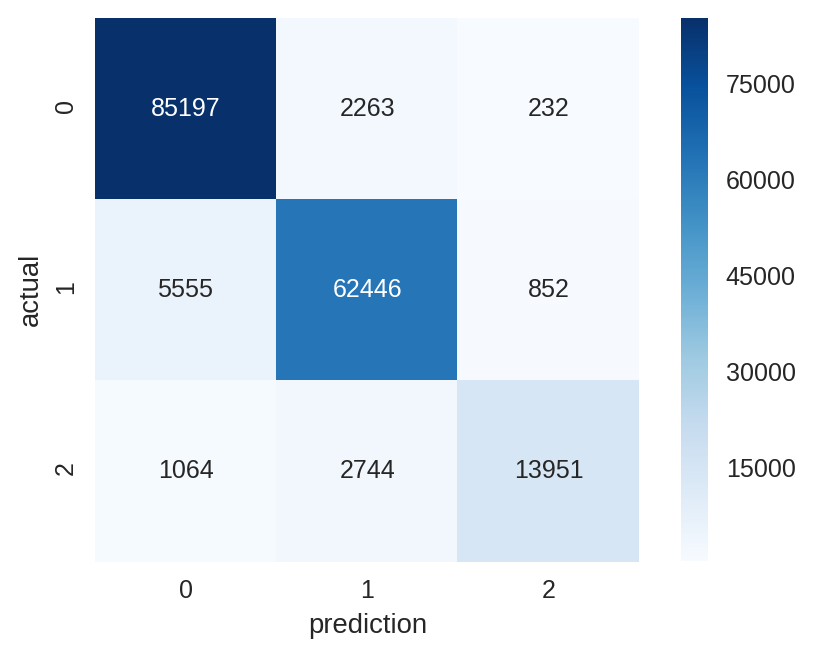

In [13]:
conf_trees(y_test, y_pred)

In [17]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

Recall for cover:
Type 0:97.15481457829677
Type 1:90.69466835141533
Type 2:78.55735120220733


In [18]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:92.79101681624118
Type 1:92.57705365217262
Type 2:92.79015630196209


### Tunning hyperparameters
High risk fires are really bad predicted. Try to solve that.

In [20]:
param_grid = {'n_estimators': [10], 'max_depth': [50,100,200,400,800], 'max_leaf_nodes':[10000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train, y_train, X_test, y_test)

Accuracy training: 0.9178624467677056
Accuracy test: 0.9255209289517166
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=10000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [10]:
param_grid = {'n_estimators': [10,100,200], 'max_depth': [100], 'max_leaf_nodes':[1000000, 5000000, 10000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train, y_train, X_test, y_test)

Accuracy training: 0.9424501116279984
Accuracy test: 0.9497601890949147
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=10000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [ ]:
param_grid = {'n_estimators': [200,400,800], 'max_depth': [100], 'max_leaf_nodes':[10000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train, y_train, X_test, y_test)

### Selecting features with importance >0.07

In [11]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train_in, y_train)
y_pred = rf.predict(X_test_in)
feature_viewer = {}
for col, score in zip(X.loc[:,:].columns, rf.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Elevation                           0.301642
Aspect                              0.274010
Slope                               0.141913
Horizontal_Distance_To_Hydrology    0.128318
Vertical_Distance_To_Hydrology      0.154117
dtype: float64

In [13]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

Recall for cover:
Type 0:95.8833188888382
Type 1:89.93072197289878
Type 2:78.19133960245509


In [14]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:92.53406114498272
Type 1:91.2722395011866
Type 2:89.02994165544656


### Hyperparameters tunning with selected features

In [10]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]

In [16]:
param_grid = {'n_estimators': [10,100], 'max_depth': [50,100,200], 'max_leaf_nodes':[1000000,10000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train_in, y_train, X_test_in, y_test)

Accuracy training: 0.9249584468463861
Accuracy test: 0.9308564347347164
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=1000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [12]:
param_grid = {'n_estimators': [100,200], 'max_depth': [50], 'max_leaf_nodes':[1000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train_in, y_train, X_test_in, y_test)

Accuracy training: 0.9258681904462169
Accuracy test: 0.9318891132733614
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=1000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [16]:
param_grid = {'n_estimators': [200], 'max_depth': [50], 'max_leaf_nodes':[1000000,5000000,10000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train_in, y_train, X_test_in, y_test)

Accuracy training: 0.9258362264818986
Accuracy test: 0.9319522214062786
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=5000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [17]:
param_grid = {'n_estimators': [200, 400], 'max_depth': [50], 'max_leaf_nodes':[5000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train_in, y_train, X_test_in, y_test)

Accuracy training: 0.9261066907953618
Accuracy test: 0.9320727005691206
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=5000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [16]:
param_grid = {'n_estimators': [400], 'max_depth': [50], 'max_leaf_nodes':[5000000]}
grid_estimator(RandomForestClassifier(), param_grid, X_train_in, y_train, X_test_in, y_test)

Accuracy training: 0.926212417754261
Accuracy test: 0.9324513493666239
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=5000000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### Visualizing results for the best model with selected features

In [10]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_in = X[col_in]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]

In [11]:
rf = RandomForestClassifier(max_leaf_nodes=5000000, max_depth=50, n_estimators=200)
rf.fit(X_train_in, y_train)
y_pred = rf.predict(X_test_in)

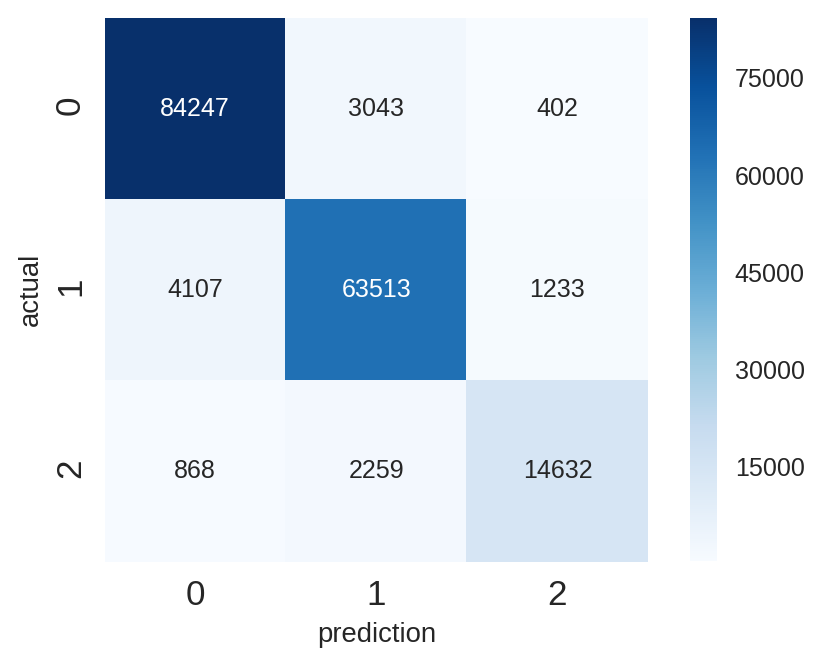

In [17]:
conf_trees(y_test, y_pred)

In [ ]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

In [ ]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

### Trying to account for the imbalance  
Oversampling

In [13]:
ros = RandomOverSampler(random_state=0)
X_train_res, y_train_res = ros.fit_sample(X_train_in,y_train)

In [14]:
rf = RandomForestClassifier(max_leaf_nodes=5000000, max_depth=50, n_estimators=200)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test_in)

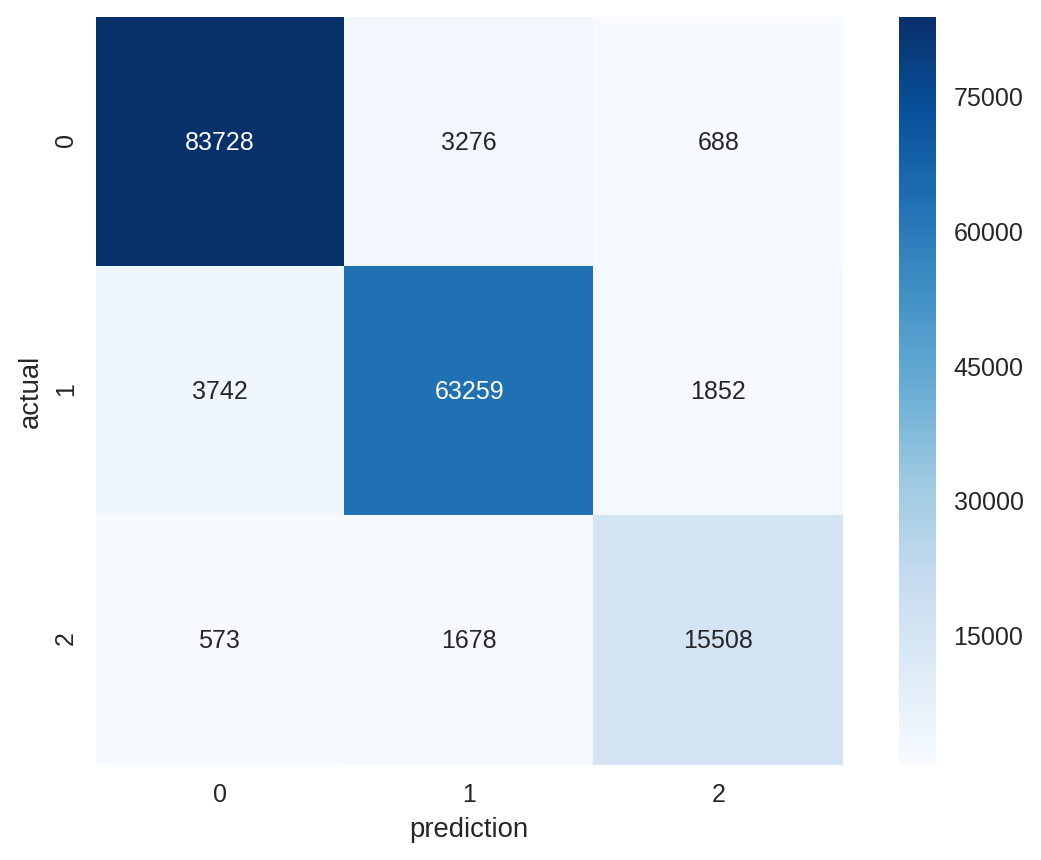

In [15]:
conf_trees(y_test, y_pred)

In [16]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

Recall for cover:
Type 0:95.4796332618711
Type 1:91.8754447881719
Type 2:87.32473675319557


In [17]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:95.0989857228854
Type 1:92.73745473736678
Type 2:85.92641843971631


Now with SMOTE

In [21]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train_in,y_train)

In [22]:
rf = RandomForestClassifier(max_leaf_nodes=5000000, max_depth=50, n_estimators=200)
rf.fit(X_smoted, y_smoted)
y_pred = rf.predict(X_test_in)

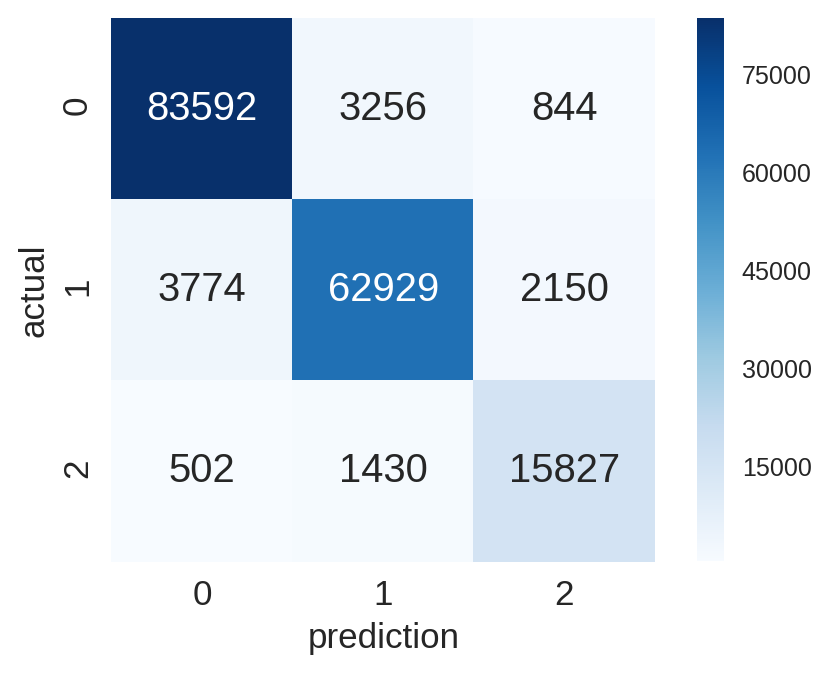

In [27]:
conf_trees(y_test, y_pred)

In [24]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

Recall for cover:
Type 0:95.3245449984035
Type 1:91.39616283967293
Type 2:89.12100906582577


In [25]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:95.13360950516685
Type 1:93.06958515122385
Type 2:84.09223739439987


Now with ADASYN

In [25]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train_in,y_train)

In [26]:
rf = RandomForestClassifier(max_leaf_nodes=5000000, max_depth=50, n_estimators=200)
rf.fit(X_adasyn, y_adasyn)
y_pred = rf.predict(X_test_in)

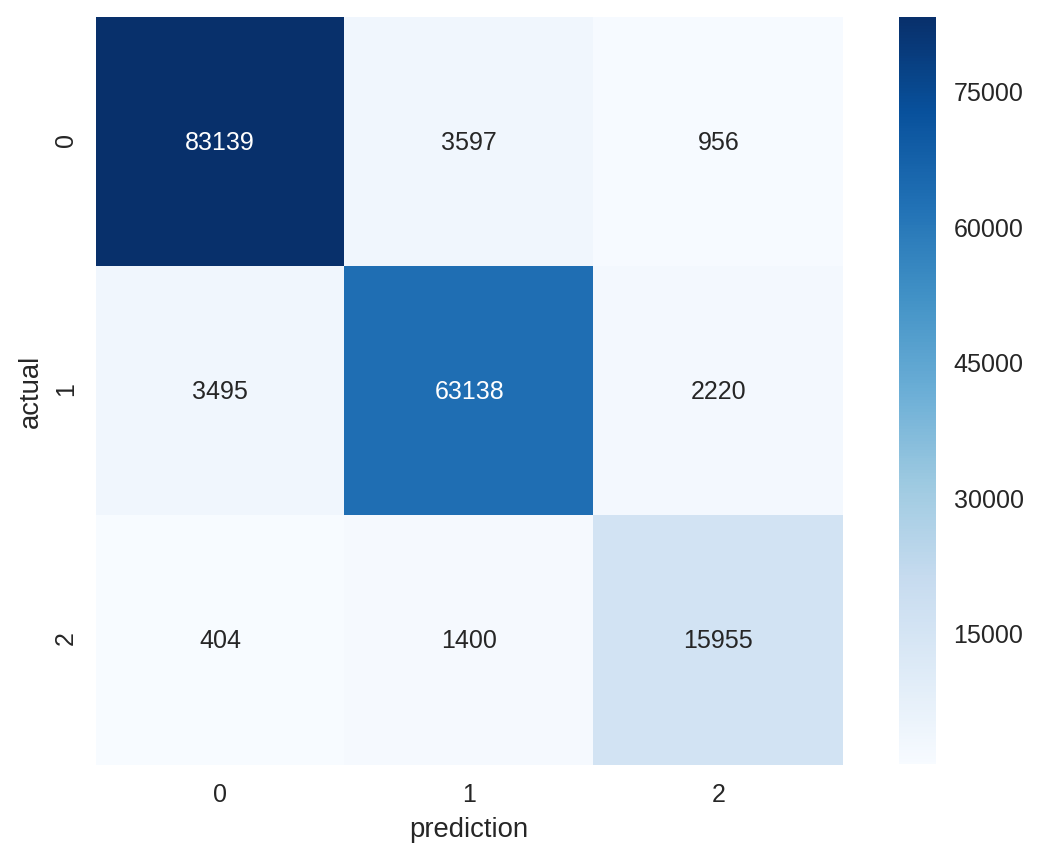

In [27]:
conf_trees(y_test, y_pred)

In [28]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

Recall for cover:
Type 0:94.80796423847102
Type 1:91.69970807372228
Type 2:89.84177036995327


In [29]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:95.52034743445391
Type 1:92.66603067439642
Type 2:83.39867231195441


### Training with the whole set with oversampling (SMOTE)

In [32]:
X_SMOTE_all, y_SMOTE_all = SMOTE(random_state=42).fit_sample(X_in,y)

In [33]:
rf = RandomForestClassifier(max_leaf_nodes=5000000, max_depth=50, n_estimators=200)
rf.fit(X_SMOTE_all, y_SMOTE_all)
y_pred = rf.predict(X_in)

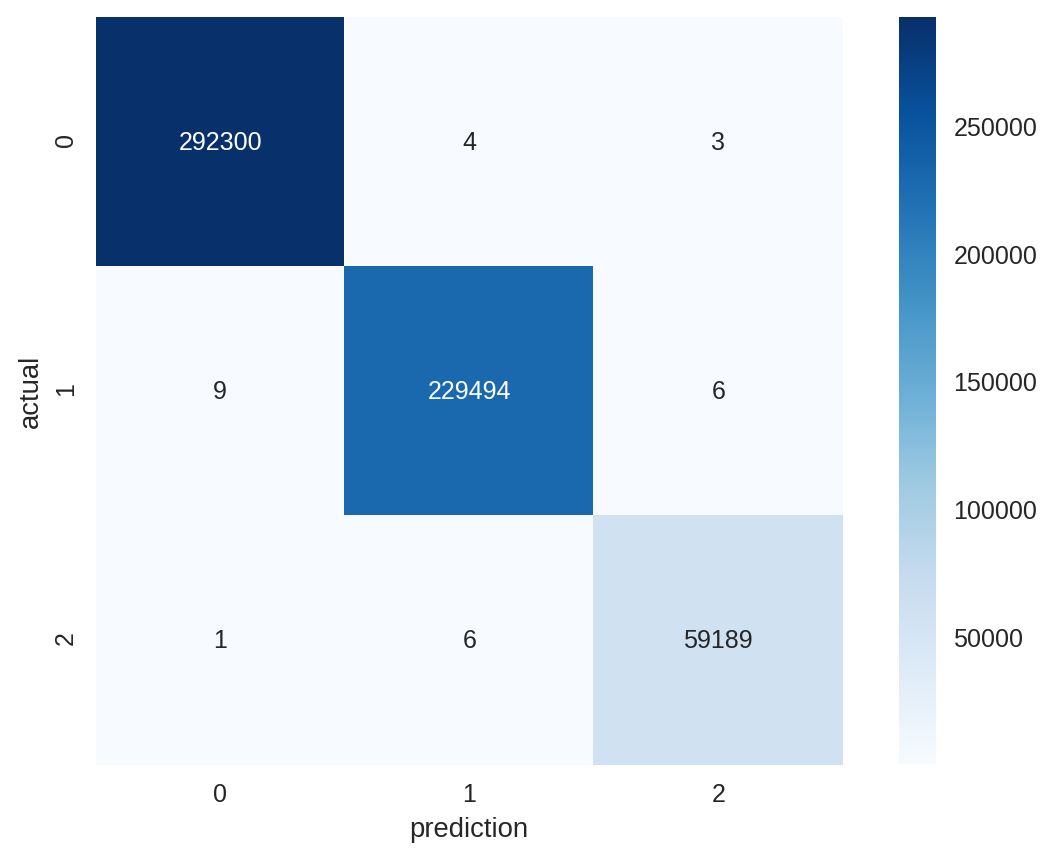

In [34]:
conf_trees(y, y_pred)

In [35]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y, y_pred)[i,i]/len(y[y==(i)])))

Recall for cover:
Type 0:99.99760525748614
Type 1:99.99346430858921
Type 2:99.98817487668086


In [36]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:99.99657897437652
Type 1:99.99564277746794
Type 2:99.98479678367512


### Training with the whole set without oversampling

In [19]:
rf = RandomForestClassifier(max_leaf_nodes=5000000, max_depth=50, n_estimators=200)
rf.fit(X_in, y)
y_pred = rf.predict(X_in)

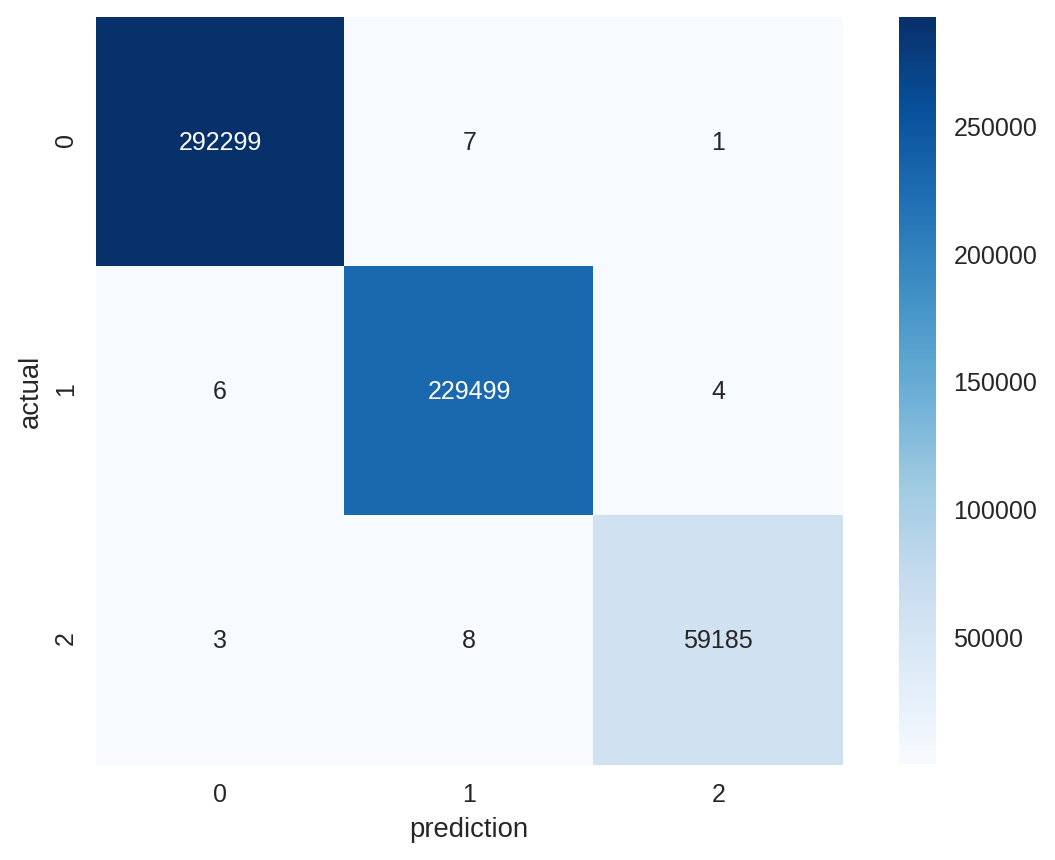

In [20]:
conf_trees(y, y_pred)

In [22]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y, y_pred)[i,i]/len(y[y==(i)])))

Recall for cover:
Type 0:99.99726315141272
Type 1:99.9956428723928
Type 2:99.98141766335563


In [23]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:99.99692105587258
Type 1:99.99346445097031
Type 2:99.99155262713296
